In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
root_path = '/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/'


# UCF

In [4]:
# we can modify this func to make sure square crop
def crop(img, startx, starty, endx, endy): 
    startx = round(startx)
    starty = round(starty)
    endx = round(endx)
    endy = round(endy)

    max_y, max_x, _ = img.shape
    startx = startx if startx > 0 else 0
    starty = starty if starty > 0 else 0
    endx = endx if endx < max_x else max_x
    endy = endy if endy < max_y else max_y
    return img[starty:endy,startx:endx]

In [ ]:
import os, cv2
import numpy as np
import keras
from keras.utils import np_utils
import sklearn
from natsort import natsorted
from matplotlib import pyplot as plt


import os, fnmatch

data_path = root_path + 'UCF/ucf_action'

img_rows=224
img_cols=224
num_channel=3
num_class = 13
frame_num = 8

data_one_crop_list=[]
data_two_crop_list=[]
label_list=[]

names_dic = {"Diving-Side": 0,
             "Golf-Swing-Back": 1,
             "Golf-Swing-Front": 2,
             "Golf-Swing-Side": 3,
             "Kicking-Front": 4,
             "Kicking-Side": 5,
             "Lifting": 6,
             "Riding-Horse": 7,
             "Run-Side": 8,
             "SkateBoarding-Front": 9,
             "Swing-Bench": 10,
             "Swing-SideAngle": 11,
             "Walk-Front": 12}

data_dir_list = os.listdir(data_path)
data_dir_list = natsorted(data_dir_list)
for class_folder in data_dir_list:
    
    video_list=os.listdir(data_path+'/'+ class_folder)
    video_list = natsorted(video_list)
    print ('Loaded the images of class-'+'{}\n'.format(class_folder))
    for vid in video_list:
        if not os.path.isdir(data_path +'/'+ class_folder + '/' + vid + '/' + "gt/"):
            continue

        frame_list=os.listdir(data_path +'/'+ class_folder + '/' + vid)
        frame_list = fnmatch.filter(frame_list, '*.jpg')

        # calculate the interval needed to extract 8 frames uniformly, 
        step = (len(frame_list) - 1) / (frame_num - 1)
        frames = [round(step * i) for i in range(0, frame_num)]
        frame_seq_one_crop = []
        frame_seq_two_crop = []

        frame_list = natsorted(frame_list)
        for index, frame in enumerate(frame_list):
            if index in frames:
                #print(frame)
                frame_data = cv2.imread(data_path +'/'+ class_folder + '/' + vid + '/' + frame)
                frame_data = cv2.cvtColor(frame_data, cv2.COLOR_BGR2RGB)
                
                gt_location_path = data_path +'/'+ class_folder + '/' + vid + '/' + "gt" + "/" + frame[:-4] + ".tif.txt"
                with open (gt_location_path, "r") as myfile:
                    gt_location = myfile.read().splitlines()
                    gt_location_list = list(map(int, gt_location[0].split("\t")[:4]))

                y_max, x_max, _ = frame_data.shape

                x1 = gt_location_list[0]
                x2 = gt_location_list[0] + gt_location_list[2]
                y1 = gt_location_list[1]
                y2 = gt_location_list[1] + gt_location_list[3]

                x_mid = (x1 + x2) / 2
                y_mid = (y1 + y2) / 2
                y_1_4 = y_mid - abs((y1 - y2)) / 4
                y_3_4 = y_mid + abs((y1 - y2)) / 4

                min_distance_from_mid = min([x_mid, y_mid, x_max - x_mid, y_max - y_mid])
                min_distance_from_mid = max([min_distance_from_mid, abs(x1 - x_mid), abs(y1 - y_mid), 50])
                # subject to change (maynot work when people is huge)
                one_crop = crop(frame_data, 
                                x_mid - min_distance_from_mid, 
                                y_mid - min_distance_from_mid,
                                x_mid + min_distance_from_mid,
                                y_mid + min_distance_from_mid)
                print(one_crop.shape)
                one_crop_resize = cv2.resize(one_crop, (img_rows, img_cols))
                
                # subject to change (not cropping according to human body)
                upper_max_distance = max([abs(x1 - x_mid), abs(x2 - x_mid), abs(y1 - y_1_4), abs(y_mid - y_1_4), 50]) + 10
                upper_crop = crop(frame_data, 
                                x_mid - upper_max_distance, 
                                y_1_4 - upper_max_distance,
                                x_mid + upper_max_distance,
                                y_1_4 + upper_max_distance)
                upper_crop_resize = cv2.resize(upper_crop, (img_rows, img_cols))

                lower_max_distance = max([abs(x1 - x_mid), abs(x2 - x_mid), abs(y2 - y_3_4), abs(y_mid - y_3_4), 50]) + 10
                lower_crop = crop(frame_data, 
                                x_mid - lower_max_distance, 
                                y_3_4 - lower_max_distance,
                                x_mid + lower_max_distance,
                                y_3_4 + lower_max_distance)
                lower_crop_resize = cv2.resize(lower_crop, (img_rows, img_cols))
                print(lower_crop.shape)

                #print(gt_location_list)
                #plt.imshow(frame_data, interpolation='nearest')
                #x = [gt_location_list[0], gt_location_list[0] + gt_location_list[2], x_mid, x_mid, x_mid]
                #y = [gt_location_list[1], gt_location_list[1] + gt_location_list[3], y_mid, y_1_4, y_3_4]
                #plt.scatter(x, y, label = "label_name" )
                #plt.show()
                frame_seq_one_crop.append(one_crop_resize)
                frame_seq_two_crop.append([upper_crop_resize, lower_crop_resize])
                
            
        data_one_crop_list.append(np.array(frame_seq_one_crop))
        data_two_crop_list.append(np.array(frame_seq_two_crop))
        label_list.append(names_dic[class_folder])

        #print(np.array(frame_seq_one_crop).shape)
        print(np.array(frame_seq_two_crop).shape)






data_one_crop = np.array(data_one_crop_list)
data_two_crop = np.array(data_two_crop_list)

data_one_crop = data_one_crop.astype('float32')
data_two_crop = data_two_crop.astype('float32')

label = np.array(label_list)
print(label)
#label_train = label_train.astype('float32')
#label_train = np_utils.to_categorical(label_train, num_class)


Loaded the images of class-Diving-Side

(369, 369, 3)
(215, 215, 3)
(401, 400, 3)
(214, 214, 3)
(376, 376, 3)
(294, 307, 3)
(228, 228, 3)
(220, 220, 3)
(349, 348, 3)
(248, 248, 3)
(342, 342, 3)
(213, 213, 3)
(324, 324, 3)
(203, 203, 3)
(371, 372, 3)
(152, 152, 3)
(8, 2, 224, 224, 3)
(367, 367, 3)
(217, 217, 3)
(367, 367, 3)
(199, 199, 3)
(303, 303, 3)
(223, 223, 3)
(332, 332, 3)
(194, 194, 3)
(403, 403, 3)
(159, 159, 3)
(232, 232, 3)
(184, 235, 3)
(226, 226, 3)
(170, 224, 3)
(184, 184, 3)
(129, 161, 3)
(8, 2, 224, 224, 3)
(397, 398, 3)
(200, 200, 3)
(357, 358, 3)
(220, 220, 3)
(298, 298, 3)
(200, 200, 3)
(335, 336, 3)
(204, 204, 3)
(344, 344, 3)
(208, 208, 3)
(333, 332, 3)
(148, 148, 3)
(269, 268, 3)
(207, 254, 3)
(254, 254, 3)
(162, 185, 3)
(8, 2, 224, 224, 3)
(303, 302, 3)
(148, 148, 3)
(397, 397, 3)
(223, 223, 3)
(318, 318, 3)
(318, 319, 3)
(210, 210, 3)
(190, 190, 3)
(252, 268, 3)
(288, 288, 3)
(237, 236, 3)
(248, 248, 3)
(326, 326, 3)
(244, 278, 3)
(290, 290, 3)
(187, 212, 3)
(8, 

In [ ]:
data_two_crop.shape

(140, 8, 2, 224, 224, 3)

In [ ]:
len(label)

140

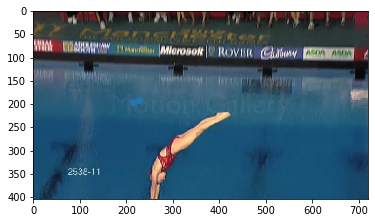

In [ ]:
plt.imshow(frame_data, interpolation='nearest')
x = [gt_location_list[0], gt_location_list[2]]
y = [gt_location_list[1], gt_location_list[3]]
plt.scatter(x, y, label = "label_name" )
plt.show()

In [ ]:
# DO NOT RUN THE FOLLOWING CODE, UNLESS YOU KNOW WHAT YOU ARE DOING

data_two_crop.shape
"""
run_save = False
if run_save:
  with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "raw_crops_rgb.npy", 'wb') as f:
      np.save(f, data_one_crop)
      np.save(f, data_two_crop)
      np.save(f, label)
"""

In [ ]:
import numpy as np

with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "raw_crops_rgb.npy", 'rb') as f:
    data_one_crop = np.load(f, allow_pickle=True)
    data_two_crop = np.load(f, allow_pickle=True)
    label = np.load(f, allow_pickle=True)


# Processing

In [ ]:
plt.imshow(frame_data, interpolation='nearest')
x = [gt_location_list[0], gt_location_list[2]]
y = [gt_location_list[1], gt_location_list[3]]
plt.scatter(x, y, label = "label_name" )
plt.show()

# Optical flow

In [12]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow

def dense_optical_flow(video_file, output_file):
    # Open video file
    cap = cv2.VideoCapture(video_file)

    # Get video dimensions
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(fps)
    print(width)
    print(height)
    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Define parameters for optical flow calculation
    lk_params = dict(winSize=(15, 15),
                     maxLevel=4,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors to display the optical flow
    color = (0, 255, 0)
    color_flow = None

    # Iterate over frames and calculate optical flow
    ret, old_frame = cap.read()
    #print(old_frame)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(old_frame)
    hsv[..., 1] = 255
    time_elapsed = 0
    frame_counter = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        start = time.time()
        flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        color_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        out.write(color_flow)
        #print('Dense Optical Flow')
        #cv2_imshow(color_flow)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        # Update previous frame and previous points
        old_gray = frame_gray.copy()
        # End time
        end = time.time()
        # calculate the FPS for current frame detection
        time_elapsed += end-start
        frame_counter += 1

        if frame_counter == 10:
          fps = frame_counter / time_elapsed
          print(f"{fps:.2f} FPS")
          frame_counter = 0
          time_elapsed = 0

    # Release video capture, release output video, and destroy windows
    cap.release()
    out.release()
    cv2.destroyAllWindows()


dense_optical_flow(root_path + 'test.avi', root_path + 'output1.mp4')

10
720
404
13.66 FPS
14.35 FPS
14.44 FPS
13.73 FPS
10.42 FPS


In [29]:
root_path + 'test.avi'

'/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/test.avi'

In [7]:
import os, cv2
import numpy as np
import keras
from keras.utils import np_utils
import sklearn
from natsort import natsorted
from matplotlib import pyplot as plt
import time
from google.colab.patches import cv2_imshow

import os, fnmatch

data_path = root_path + 'UCF/ucf_action'

names_dic = {"Diving-Side": 0,
             "Golf-Swing-Back": 1,
             "Golf-Swing-Front": 2,
             "Golf-Swing-Side": 3,
             "Kicking-Front": 4,
             "Kicking-Side": 5,
             "Lifting": 6,
             "Riding-Horse": 7,
             "Run-Side": 8,
             "SkateBoarding-Front": 9,
             "Swing-Bench": 10,
             "Swing-SideAngle": 11,
             "Walk-Front": 12}
counter = 0
data_dir_list = os.listdir(data_path)
data_dir_list = natsorted(data_dir_list)
for class_folder in data_dir_list:

    video_list= os.listdir(data_path+'/'+ class_folder)
    video_list = natsorted(video_list)
    print ('working on video of class-'+'{}\n'.format(class_folder))
    for vid in video_list:
        if os.path.isdir(data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow/"):
          continue

        file_list=os.listdir(data_path +'/'+ class_folder + '/' + vid)
        video_path = fnmatch.filter(file_list, '*.avi')

        if len (video_path) == 0:
          continue
        else:
          video_path = video_path[0]

        counter += 1
        os.mkdir(data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow")
        dense_optical_flow(data_path +'/'+ class_folder + '/' + vid + '/' + video_path, data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow" + '/' + video_path[:-4] + '.mp4')
        #print(data_path +'/'+ class_folder + '/' + vid + '/' + video_path)
        #print(data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow" + '/' + video_path[:-4] + '.mp4')


working on video of class-Diving-Side

working on video of class-Golf-Swing-Back

working on video of class-Golf-Swing-Front

working on video of class-Golf-Swing-Side

working on video of class-Kicking-Front

working on video of class-Kicking-Side

working on video of class-Lifting



NameError: ignored

In [14]:
import os, cv2
import numpy as np
import keras
from keras.utils import np_utils
import sklearn
from natsort import natsorted
from matplotlib import pyplot as plt
import shutil

import os, fnmatch

data_path = root_path + 'UCF/ucf_action'

img_rows=224
img_cols=224
num_channel=3
num_class = 13
frame_num = 8

data_one_crop_list=[]
data_two_crop_list=[]

flow_one_crop_list=[]
flow_two_crop_list=[]

label_list=[]

names_dic = {"Diving-Side": 0,
             "Golf-Swing-Back": 1,
             "Golf-Swing-Front": 2,
             "Golf-Swing-Side": 3,
             "Kicking-Front": 4,
             "Kicking-Side": 5,
             "Lifting": 6,
             "Riding-Horse": 7,
             "Run-Side": 8,
             "SkateBoarding-Front": 9,
             "Swing-Bench": 10,
             "Swing-SideAngle": 11,
             "Walk-Front": 12}

data_dir_list = os.listdir(data_path)
data_dir_list = natsorted(data_dir_list)
for class_folder in data_dir_list:
    
    video_list=os.listdir(data_path+'/'+ class_folder)
    video_list = natsorted(video_list)
    print ('Loaded the images of class-'+'{}\n'.format(class_folder))
    for vid in video_list:
        if not os.path.isdir(data_path +'/'+ class_folder + '/' + vid + '/' + "gt/"):
            continue


        dirpath = os.path.join('dataset3', 'dataset')
        if os.path.exists(data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow"):
            shutil.rmtree(data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow")

        os.mkdir(data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow")

        frame_list=os.listdir(data_path +'/'+ class_folder + '/' + vid)
        frame_list = fnmatch.filter(frame_list, '*.jpg')

        # calculate the interval needed to extract 8 frames uniformly, 
        step = (len(frame_list) - 1) / (frame_num - 1)
        frames = [round(step * i) for i in range(0, frame_num)]
        
        frame_seq_one_crop = []
        frame_seq_two_crop = []
        flow_seq_one_crop = []
        flow_seq_two_crop = []

        frame_list = natsorted(frame_list)

        ## optical flow
        output_file = data_path +'/'+ class_folder + '/' + vid + '/' + "optical_flow" + '/' + frame_list[0][:-4] + '.mp4'
        old_frame = cv2.imread(data_path +'/'+ class_folder + '/' + vid + '/' + frame_list[0])
        # Get video dimensions

        height, width, _ = old_frame.shape
        fps = 10
        print(height, width)
        # Define codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

        # Define parameters for optical flow calculation
        lk_params = dict(winSize=(15, 15),
                        maxLevel=4,
                        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

        # Create some random colors to display the optical flow
        color = (0, 255, 0)
        color_flow = None

        # Iterate over frames and calculate optical flow

        #print(old_frame)
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        hsv = np.zeros_like(old_frame)
        hsv[..., 1] = 255
        time_elapsed = 0
        frame_counter = 0

        

        for index, frame in enumerate(frame_list):
                    
            frame_data = cv2.imread(data_path +'/'+ class_folder + '/' + vid + '/' + frame)
            frame_gray = cv2.cvtColor(frame_data, cv2.COLOR_BGR2GRAY)
            start = time.time()
            flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            color_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            out.write(color_flow)
            #print('Dense Optical Flow')
            #cv2_imshow(color_flow)
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break
            # Update previous frame and previous points
            old_gray = frame_gray.copy()
            # End time
            end = time.time()
            # calculate the FPS for current frame detection
            time_elapsed += end-start
            frame_counter += 1

            if frame_counter == 10:
              fps = frame_counter / time_elapsed
              print(f"{fps:.2f} FPS")
              frame_counter = 0
              time_elapsed = 0


            if index in frames:
                #print(frame)
                #frame_data = cv2.imread(data_path +'/'+ class_folder + '/' + vid + '/' + frame)
                frame_data = cv2.cvtColor(frame_data, cv2.COLOR_BGR2RGB)
                
                gt_location_path = data_path +'/'+ class_folder + '/' + vid + '/' + "gt" + "/" + frame[:-4] + ".tif.txt"
                with open (gt_location_path, "r") as myfile:
                    gt_location = myfile.read().splitlines()
                    gt_location_list = list(map(int, gt_location[0].split("\t")[:4]))

                y_max, x_max, _ = frame_data.shape

                x1 = gt_location_list[0]
                x2 = gt_location_list[0] + gt_location_list[2]
                y1 = gt_location_list[1]
                y2 = gt_location_list[1] + gt_location_list[3]

                x_mid = (x1 + x2) / 2
                y_mid = (y1 + y2) / 2
                y_1_4 = y_mid - abs((y1 - y2)) / 4
                y_3_4 = y_mid + abs((y1 - y2)) / 4

                min_distance_from_mid = min([x_mid, y_mid, x_max - x_mid, y_max - y_mid])
                min_distance_from_mid = max([min_distance_from_mid, abs(x1 - x_mid), abs(y1 - y_mid), 50])
                # subject to change (maynot work when people is huge)
                one_crop = crop(frame_data, 
                                x_mid - min_distance_from_mid, 
                                y_mid - min_distance_from_mid,
                                x_mid + min_distance_from_mid,
                                y_mid + min_distance_from_mid)
                #print(one_crop.shape)
                one_crop_resize = cv2.resize(one_crop, (img_rows, img_cols))

                color_flow_one_crop = crop(color_flow, 
                                x_mid - min_distance_from_mid, 
                                y_mid - min_distance_from_mid,
                                x_mid + min_distance_from_mid,
                                y_mid + min_distance_from_mid)
                
                color_flow_one_crop_resize = cv2.resize(color_flow_one_crop, (img_rows, img_cols))

                
                # subject to change (not cropping according to human body)
                upper_max_distance = max([abs(x1 - x_mid), abs(x2 - x_mid), abs(y1 - y_1_4), abs(y_mid - y_1_4), 50]) + 10
                upper_crop = crop(frame_data, 
                                x_mid - upper_max_distance, 
                                y_1_4 - upper_max_distance,
                                x_mid + upper_max_distance,
                                y_1_4 + upper_max_distance)
                upper_crop_resize = cv2.resize(upper_crop, (img_rows, img_cols))


                color_flow_upper_crop = crop(color_flow, 
                                x_mid - upper_max_distance, 
                                y_1_4 - upper_max_distance,
                                x_mid + upper_max_distance,
                                y_1_4 + upper_max_distance)
                
                color_flow_upper_crop_resize = cv2.resize(color_flow_upper_crop, (img_rows, img_cols))

                lower_max_distance = max([abs(x1 - x_mid), abs(x2 - x_mid), abs(y2 - y_3_4), abs(y_mid - y_3_4), 50]) + 10
                lower_crop = crop(frame_data, 
                                x_mid - lower_max_distance, 
                                y_3_4 - lower_max_distance,
                                x_mid + lower_max_distance,
                                y_3_4 + lower_max_distance)
                lower_crop_resize = cv2.resize(lower_crop, (img_rows, img_cols))

                color_flow_lower_crop = crop(color_flow, 
                                x_mid - lower_max_distance, 
                                y_3_4 - lower_max_distance,
                                x_mid + lower_max_distance,
                                y_3_4 + lower_max_distance)
                
                color_flow_lower_crop_resize = cv2.resize(color_flow_lower_crop, (img_rows, img_cols))

                #print(lower_crop.shape)

                #print(gt_location_list)
                #plt.imshow(frame_data, interpolation='nearest')
                #x = [gt_location_list[0], gt_location_list[0] + gt_location_list[2], x_mid, x_mid, x_mid]
                #y = [gt_location_list[1], gt_location_list[1] + gt_location_list[3], y_mid, y_1_4, y_3_4]
                #plt.scatter(x, y, label = "label_name" )
                #plt.show()
                frame_seq_one_crop.append(one_crop_resize)
                frame_seq_two_crop.append([upper_crop_resize, lower_crop_resize])


                flow_seq_one_crop.append(color_flow_one_crop_resize)
                flow_seq_two_crop.append([color_flow_upper_crop_resize, color_flow_lower_crop_resize])
            
        data_one_crop_list.append(np.array(frame_seq_one_crop))
        data_two_crop_list.append(np.array(frame_seq_two_crop))
        flow_one_crop_list.append(np.array(flow_seq_one_crop))
        flow_two_crop_list.append(np.array(flow_seq_two_crop))
        label_list.append(names_dic[class_folder])

        #print(np.array(frame_seq_one_crop).shape)
        #print(np.array(frame_seq_two_crop).shape)

        # Release video capture, release output video, and destroy windows
        out.release()
        cv2.destroyAllWindows()

data_one_crop = np.array(data_one_crop_list)
data_two_crop = np.array(data_two_crop_list)
flow_one_crop = np.array(flow_one_crop_list)
flow_two_crop = np.array(flow_two_crop_list)

data_one_crop = data_one_crop.astype('float32')
data_two_crop = data_two_crop.astype('float32')
flow_one_crop = flow_one_crop.astype('float32')
flow_two_crop = flow_two_crop.astype('float32')

label = np.array(label_list)
print(label)
#label_train = label_train.astype('float32')
#label_train = np_utils.to_categorical(label_train, num_class)


Loaded the images of class-Diving-Side

404 720
14.31 FPS
14.57 FPS
14.28 FPS
14.26 FPS
14.12 FPS
404 720
14.90 FPS
10.86 FPS
10.68 FPS
11.02 FPS
14.35 FPS
404 720
14.85 FPS
14.81 FPS
14.50 FPS
14.28 FPS
14.35 FPS
404 720
14.70 FPS
14.66 FPS
12.69 FPS
13.37 FPS
13.98 FPS
404 720
13.86 FPS
14.35 FPS
14.71 FPS
9.41 FPS
14.63 FPS
404 720
12.80 FPS
14.10 FPS
14.58 FPS
14.60 FPS
12.41 FPS
404 720
15.10 FPS
12.35 FPS
14.74 FPS
14.91 FPS
13.22 FPS
404 720
14.94 FPS
14.62 FPS
12.24 FPS
14.56 FPS
14.96 FPS
404 720
13.14 FPS
14.90 FPS
14.48 FPS
12.36 FPS
14.38 FPS
404 720
13.25 FPS
14.21 FPS
14.92 FPS
13.26 FPS
14.43 FPS
404 720
14.47 FPS
12.13 FPS
14.91 FPS
14.46 FPS
13.55 FPS
404 720
14.97 FPS
12.93 FPS
14.34 FPS
14.58 FPS
12.21 FPS
404 720
15.07 FPS
14.69 FPS
12.41 FPS
14.54 FPS
14.63 FPS
404 720
12.08 FPS
14.75 FPS
14.88 FPS
12.49 FPS
11.86 FPS
Loaded the images of class-Golf-Swing-Back

400 250
45.70 FPS
37.08 FPS
45.37 FPS
44.05 FPS
44.72 FPS
38.14 FPS
400 250
45.28 FPS
43.89 FPS
38.56 FPS

In [9]:
old_frame.shape

(404, 720, 3)

In [ ]:
#print(np.array(frame_seq_two_crop).shape)

In [47]:
flow_two_crop.shape


(1, 8, 2, 224, 224, 3)

In [15]:
# DO NOT RUN THE FOLLOWING CODE, UNLESS YOU KNOW WHAT YOU ARE DOING


run_save = True
if run_save:
  with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "raw_crops_rgb_and_flow_2.npy", 'wb') as f:
      np.save(f, data_one_crop)
      np.save(f, data_two_crop)
      np.save(f, flow_one_crop)
      np.save(f, flow_two_crop)
      np.save(f, label)


In [ ]:
import numpy as np

with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "raw_crops_rgb_and_flow.npy", 'rb') as f:
    data_one_crop = np.load(f, allow_pickle=True)
    data_two_crop = np.load(f, allow_pickle=True)
    flow_one_crop = np.load(f, allow_pickle=True)
    flow_two_crop = np.load(f, allow_pickle=True)
    label = np.load(f, allow_pickle=True)
